## Cats and Dogs (1/2)
### Building powerful image classification models using very little data
By Francois Chollet: 
https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

Esta é parte 2 de três sobre *transfer learning*.

Neste notebook utilizam-se as camadas convolucionais de uma rede VGG já treinada para gerar as "características" das imagens e treina-se com uma rede neural densa de duas camadas. 

In [1]:
import os
os.environ['KERAS_BACKEND'] = 'theano'
os.environ['THEANO_FLAGS'] = 'mode=FAST_RUN,device=gpu0,floatX=float32'
# os.environ['THEANO_FLAGS'] = 'mode=FAST_RUN,device=cpu,floatX=float32'

In [2]:
%matplotlib inline
import matplotlib.pyplot as plot
from IPython import display

import os
import sys
import numpy as np
import numpy.random as nr

import theano
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

print 'Keras ', keras.__version__
print 'Theano', theano.__version__


Using gpu device 0: GRID K520 (CNMeM is disabled, cuDNN 5110)
/opt/conda/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)
Using Theano backend.


Keras  1.2.0
Theano 0.8.2


## Dataset

https://www.kaggle.com/c/dogs-vs-cats/data


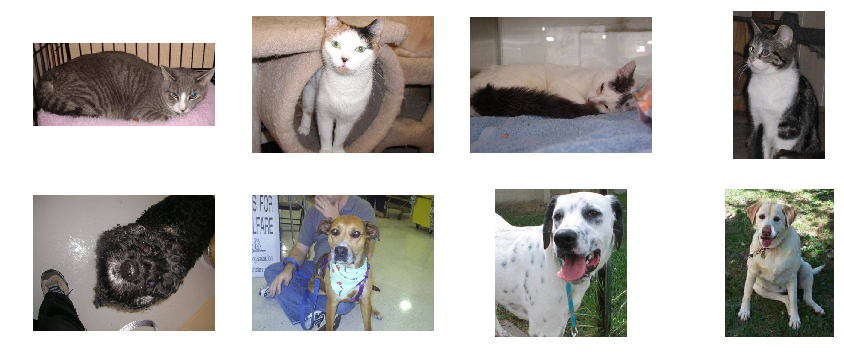

In [3]:
train_data_dir = '/root/CatsDogs/train'
validation_data_dir = '/root/CatsDogs/validation'
nb_train_samples = 2000
nb_validation_samples = 800

fig = plot.figure(figsize=(15,6))
for i, j in enumerate(nr.randint(0, 1000, 4)):
    fig.add_subplot(2,4, i+1)
    img = plot.imread('{}/cats/cat.{}.jpg'.format(train_data_dir, j))
    plot.imshow(img)
    plot.axis('off')
    
    fig.add_subplot(2,4, i+5)
    img = plot.imread('{}/dogs/dog.{}.jpg'.format(train_data_dir, j))
    plot.imshow(img)    
    plot.axis('off')


In [4]:
# dimensions of our images.
img_width, img_height = 150, 150

datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode='binary',
    shuffle=False,
)

validation_generator = datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode='binary',
    shuffle=False,
)


Found 2000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


## VGG Features

[![VGG Network Layers](https://blog.keras.io/img/imgclf/vgg16_original.png)]()

In [5]:
def get_and_save_vgg_features(trn_feat_fn, val_feat_fn):
    from keras.applications.vgg16 import VGG16
    vgg = VGG16(include_top=False, weights='imagenet', input_shape=(3, img_height, img_width))
    train_features = vgg.predict_generator(train_generator, nb_train_samples)
    np.save(open(trn_feat_fn, 'w'), train_features)
    validation_features = vgg.predict_generator(validation_generator, nb_validation_samples)
    np.save(open(val_feat_fn, 'w'), validation_features)
    return train_features, validation_features

trn_feat_fn = '../../models/vgg16_150x150_features_train.npy'
val_feat_fn = '../../models/vgg16_150x150_features_valid.npy'

if not os.path.isfile(trn_feat_fn):
    train_features, validation_features = get_and_save_vgg_features(trn_feat_fn, val_feat_fn)
else:
    train_features = np.load(open(trn_feat_fn))
    validation_features = np.load(open(val_feat_fn))
    
train_labels = np.array([0] * 1000 + [1] * 1000)
validation_labels = np.array([0] * 400 + [1] * 400)

## Modelo
A rede neural utilizada é especificada a seguir.

In [6]:
class MyNet:
    @staticmethod
    def build(img_width, img_height):
        model = Sequential()
        model.add(Flatten(input_shape=train_features.shape[1:]))
        model.add(Dense(256, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(1, activation='sigmoid'))
        return model

MyNet.build(img_width, img_height).summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
flatten_1 (Flatten)              (None, 8192)          0           flatten_input_1[0][0]            
____________________________________________________________________________________________________
dense_1 (Dense)                  (None, 256)           2097408     flatten_1[0][0]                  
____________________________________________________________________________________________________
dropout_1 (Dropout)              (None, 256)           0           dense_1[0][0]                    
____________________________________________________________________________________________________
dense_2 (Dense)                  (None, 1)             257         dropout_1[0][0]                  
Total params: 2,097,665
Trainable params: 2,097,665
Non-trainable params: 0
_______________

In [7]:
os.sys.path.append('../src/')
from my_keras_utilities import (load_model_and_history, 
                                save_model_and_history, 
                                TrainingPlotter)

model_name = '../../models/cats_dogs_vgg'

if not os.path.isfile(model_name + '.model'):
    print("[INFO] creating model...")
    model = MyNet.build(img_width, img_height)
    
    # History, checkpoint, earlystop, plot losses:
    histo = TrainingPlotter(n=1, filepath=model_name, patience=15)
    
    # initialize the optimizer and model
    print("[INFO] compiling model...")
    model.compile(loss="binary_crossentropy", optimizer='adadelta', metrics=["accuracy"])    
    
else:
    print("[INFO] loading model...")
    model, histo = load_model_and_history(model_name)


[INFO] loading model...


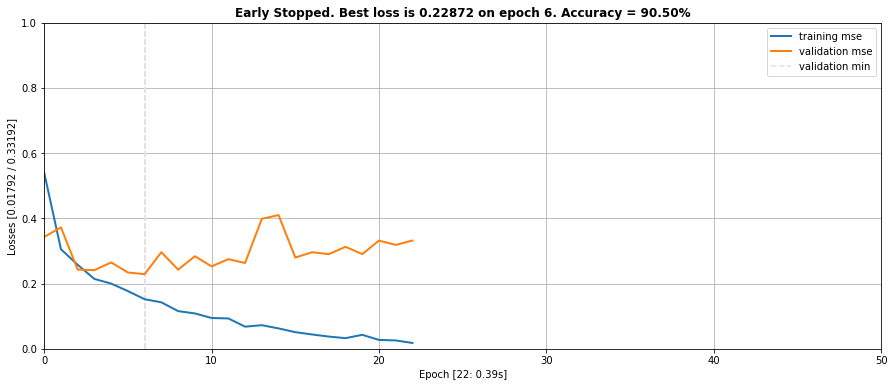

In [8]:
nb_epoch = 50
ploss = 1.0

nepochs = nb_epoch - histo.get_nepochs()

fig = plot.figure(figsize=(15,6))
plot.ylim(0.0, ploss)
plot.xlim(0, nb_epoch)
plot.grid(True)

if nepochs > 0:
    print("[INFO] training...")
    try:
        model.fit(train_features, train_labels,
                  nb_epoch=nepochs, batch_size=32, verbose=0,
                  callbacks=[histo],
                  validation_data=(validation_features, validation_labels))
    except KeyboardInterrupt:
        pass
else:
    print("[INFO] plotting...")
    # plot history


In [9]:
print("[INFO] loading model...")
model, histo = load_model_and_history(model_name)
print("[INFO] evaluating...")
loss, accuracy = model.evaluate(validation_features, validation_labels, batch_size=128, verbose=1)
print("[INFO] accuracy: {:.2f}%".format(accuracy * 100))


[INFO] loading model...
[INFO] evaluating...
640/800 [=======================>......] - ETA: 0s[INFO] accuracy: 90.50%


## Aprendizados com este notebook

- Uso de rede pré-treinada em base maior, que já aprendeu atributos que não seriam aprendidos por um conjunto de dados mais limitado
- as features geradas pela vgg podem ser usadas por outro classificador
